In [1]:
import sys
sys.path.append('/home/sdu123/WORK/KODE')

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchdiffeq import odeint
import pandas as pd
from base_kan.ekan import EKAN  

In [ ]:
class CustomSIRSystem(nn.Module):
    def __init__(self, neural_part, gamma, beta):
        super(CustomSIRSystem, self).__init__()
        self.neural_part = neural_part
        self.gamma = gamma
        self.beta = beta
        self.neural_outputs = []  

    def forward(self, t, y):
        S, I, R = y
        neural_output = self.neural_part(torch.tensor([S,I], dtype=torch.float32).unsqueeze(0)).squeeze()
        self.neural_outputs.append(neural_output.detach().numpy())  
        dR_dt = self.gamma * I
        dI_dt = abs(neural_output) - self.gamma * I
        dS_dt = - abs (neural_output)
        return torch.stack([dS_dt, dI_dt, dR_dt])

In [ ]:
gamma = 0.07
beta = 2 * gamma  
neural_ode_func = EKAN(layers_hidden=[2, 128, 1])
model = CustomSIRSystem(neural_ode_func, gamma, beta)

In [ ]:
intial = 0. 
last= 80.   
step = 80   
y0 = torch.tensor([0.99, 0.01, 0.0], requires_grad=True) 
t = torch.linspace(intial, last, step)  

In [6]:
def get_data():
    gamma = 0.07
    beta = 2 * gamma
    true_y0 = torch.tensor([0.99, 0.01, 0.0])
    def sir(t, y):
        S, I, R = y
        dS_dt = -beta * S * I
        dI_dt = beta * S * I - gamma * I
        dR_dt = gamma * I
        return torch.stack([dS_dt, dI_dt, dR_dt])
    with torch.no_grad():
        true_y = odeint(sir, true_y0, t, rtol=1e-5, atol=1e-8)
    return t, true_y

t, true_y = get_data()

In [7]:
def compute_loss(pred_y, true_y):
    return torch.mean((pred_y[:, 2] - true_y[:, 2]) ** 2)

In [8]:
def compute_accuracy(pred_y, true_y, threshold=0.01):
    diff = torch.abs(pred_y[:, 2] - true_y[:, 2])
    correct = (diff < threshold).float().mean()
    return correct.item()

In [9]:
def train():
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for itr in range(3000):
        optimizer.zero_grad()
        pred_y = odeint(model, y0, t, rtol=1e-5, atol=1e-8)
        loss = compute_loss(pred_y, true_y)
        loss.backward()
        optimizer.step()

        if itr % 100 == 0:
            accuracy = compute_accuracy(pred_y, true_y)
            print(f'Iter {itr}, Loss: {loss.item()}, Accuracy: {accuracy * 100:.2f}%')

    return t, true_y, pred_y, model.neural_outputs

In [10]:
t, true_y, pred_y, neural_outputs = train()

Iter 0, Loss: 0.21440191566944122, Accuracy: 3.75%
Iter 100, Loss: 0.00905058067291975, Accuracy: 8.75%
Iter 200, Loss: 0.0073003522120416164, Accuracy: 10.00%
Iter 300, Loss: 0.005049051251262426, Accuracy: 12.50%
Iter 400, Loss: 0.0025901056360453367, Accuracy: 15.00%
Iter 500, Loss: 0.000829724594950676, Accuracy: 23.75%
Iter 600, Loss: 0.0001603802083991468, Accuracy: 45.00%
Iter 700, Loss: 2.247176962555386e-05, Accuracy: 100.00%
Iter 800, Loss: 4.611393705999944e-06, Accuracy: 100.00%
Iter 900, Loss: 2.97455790132517e-06, Accuracy: 100.00%
Iter 1000, Loss: 2.7832338673761114e-06, Accuracy: 100.00%
Iter 1100, Loss: 2.660894779182854e-06, Accuracy: 100.00%
Iter 1200, Loss: 2.530556230340153e-06, Accuracy: 100.00%
Iter 1300, Loss: 2.3969605535967276e-06, Accuracy: 100.00%
Iter 1400, Loss: 2.261125018776511e-06, Accuracy: 100.00%
Iter 1500, Loss: 2.123831563949352e-06, Accuracy: 100.00%
Iter 1600, Loss: 1.9875681118719513e-06, Accuracy: 100.00%
Iter 1700, Loss: 1.8508542325434973e-06

In [ ]:
def forword_CF(x):

    x = torch.tensor(x, dtype=torch.float32).clone().detach()
    
  
    if x.size(0) < 2:
        raise ValueError("Input tensor must have at least 2 elements.")
    
 
    result = x.clone().detach()
    

    result[1:] = x[1:] - x[:-1]
    
    return result

In [12]:
true_y[:,2] = forword_CF(true_y[:,2])
pred_y[:,2] = forword_CF(pred_y[:,2])

/tmp/ipykernel_3080050/3501744976.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach()


In [13]:
data = {
    'Time': t.numpy(),
    'True_S': true_y.numpy()[:, 0],
    'Predicted_S': pred_y.detach().numpy()[:, 0],
    'True_I': true_y.numpy()[:, 1],
    'Predicted_I': pred_y.detach().numpy()[:, 1],
    'True_R': true_y.numpy()[:, 2],
    'Predicted_R': pred_y.detach().numpy()[:, 2],

}
df = pd.DataFrame(data)


In [14]:
df.to_excel('result/YC_R_Z.xlsx', index=False)

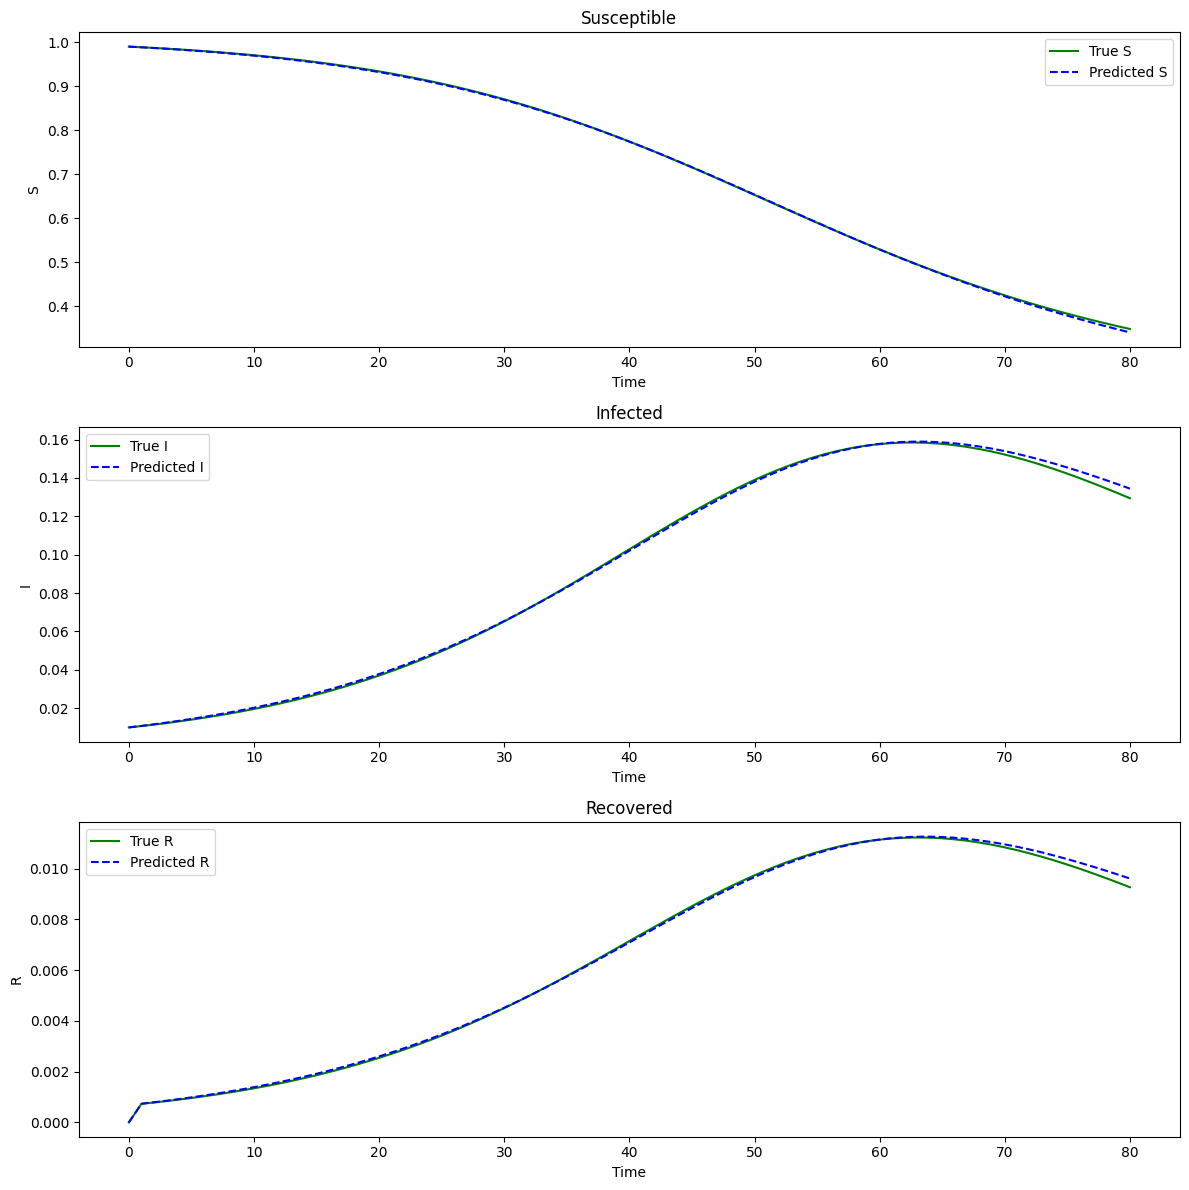

In [15]:
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(t.numpy(), true_y.numpy()[:, 0], 'g-', label='True S')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 0], 'b--', label='Predicted S')
plt.legend()
plt.xlabel('Time')
plt.ylabel('S')
plt.title('Susceptible')

plt.subplot(3, 1, 2)
plt.plot(t.numpy(), true_y.numpy()[:, 1], 'g-', label='True I')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 1], 'b--', label='Predicted I')
plt.legend()
plt.xlabel('Time')
plt.ylabel('I')
plt.title('Infected')

plt.subplot(3, 1, 3)
plt.plot(t.numpy(), true_y.numpy()[:, 2], 'g-', label='True R')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 2], 'b--', label='Predicted R')
plt.legend()
plt.xlabel('Time')
plt.ylabel('R')
plt.title('Recovered')

plt.tight_layout()
plt.savefig('picture/YC_R_Z_SIR.png')
plt.show()


In [ ]:

extend = 40
timeintial = intial
timeend = last + extend
timestep = step + extend
in_t = torch.linspace(timeintial, timeend, timestep)

In [17]:
def get_data():
    gamma = 0.07
    beta = 2 * gamma
    true_y0 = torch.tensor([0.99, 0.01, 0.0])
    def sir(t, y):
        S, I, R = y
        dS_dt = -beta * S * I
        dI_dt = beta * S * I  - gamma * I
        dR_dt = gamma * I
        return torch.stack([dS_dt, dI_dt, dR_dt])
    with torch.no_grad():
        in_true_y = odeint(sir, true_y0, in_t, rtol=1e-5, atol=1e-8)
    return in_t, in_true_y

in_t, in_true_y = get_data()

In [18]:
with torch.no_grad():
    in_pred_y = odeint(model, y0, in_t, rtol=1e-5, atol=1e-8)

In [ ]:
def forword_CF(x):
  
    x = torch.tensor(x, dtype=torch.float32).clone().detach()
    

    if x.size(0) < 2:
        raise ValueError("Input tensor must have at least 2 elements.")
    

    result = x.clone().detach()
    

    result[1:] = x[1:] - x[:-1]
    
    return result

In [20]:
in_true_y[:,2] = forword_CF(in_true_y[:,2])
in_pred_y[:,2] = forword_CF(in_pred_y[:,2])

/tmp/ipykernel_3080050/3501744976.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach()


In [21]:
in_data = {
    'Time': in_t.numpy(),
    'in_True_S': in_true_y.numpy()[:, 0],
    'in_Predicted_S': in_pred_y.detach().numpy()[:, 0],
    'in_True_I': in_true_y.numpy()[:, 1],
    'in_Predicted_I': in_pred_y.detach().numpy()[:, 1],
    'in_True_R': in_true_y.numpy()[:, 2],
    'in_Predicted_R': in_pred_y.detach().numpy()[:, 2],
}
in_df = pd.DataFrame(in_data)
in_df.to_excel('result/in_YC_R_Z.xlsx', index=False)

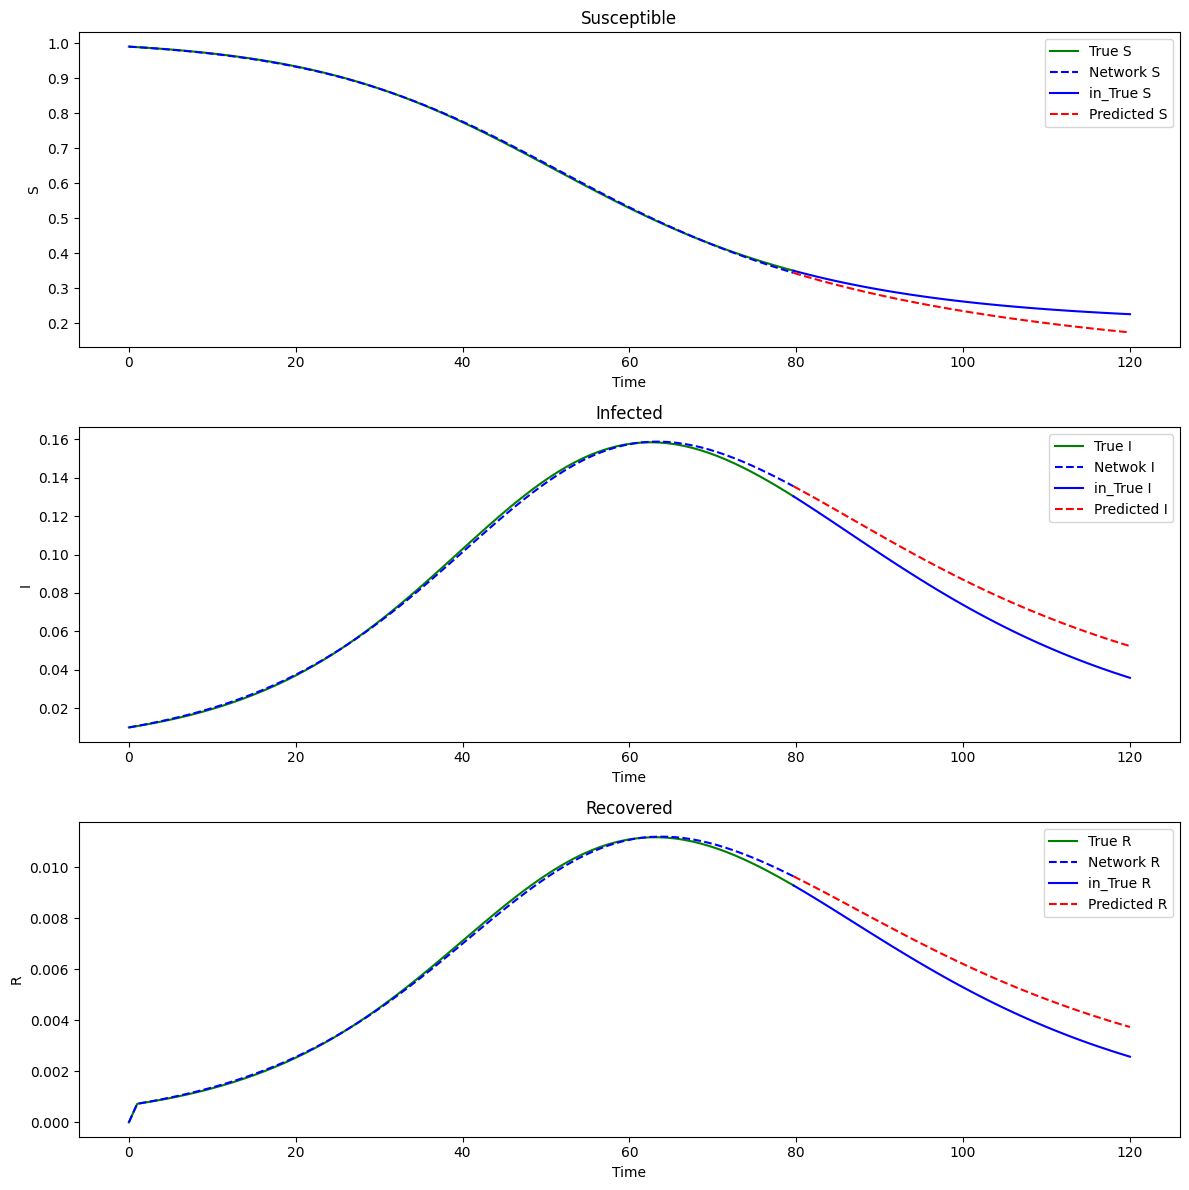

In [22]:
last = int(last)
timeend = int(timeend)
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(in_t.numpy()[:last], in_true_y.numpy()[:last, 0], 'g-', label='True S')
plt.plot(in_t.numpy()[:last], in_pred_y.detach().numpy()[:last, 0], 'b--', label='Network S')
plt.plot(in_t.numpy()[last-1:timeend], in_true_y.numpy()[last-1:timeend, 0], 'b-', label='in_True S')
plt.plot(in_t.numpy()[last-1:timeend], in_pred_y.detach().numpy()[last-1:timeend, 0], 'r--', label='Predicted S')
plt.legend()
plt.xlabel('Time')
plt.ylabel('S')
plt.title('Susceptible')

plt.subplot(3, 1, 2)
plt.plot(in_t.numpy()[:last], in_true_y.numpy()[:last, 1], 'g-', label='True I')
plt.plot(in_t.numpy()[:last], in_pred_y.detach().numpy()[:last, 1], 'b--', label='Netwok I')
plt.plot(in_t.numpy()[last-1:timeend], in_true_y.numpy()[last-1:timeend, 1], 'b-', label='in_True I')
plt.plot(in_t.numpy()[last-1:timeend], in_pred_y.detach().numpy()[last-1:timeend, 1], 'r--', label='Predicted I')
plt.legend()
plt.xlabel('Time')
plt.ylabel('I')
plt.title('Infected')

plt.subplot(3, 1, 3)
plt.plot(in_t.numpy()[:last], in_true_y.numpy()[:last, 2], 'g-', label='True R')
plt.plot(in_t.numpy()[:last], in_pred_y.detach().numpy()[:last, 2], 'b--', label='Network R')
plt.plot(in_t.numpy()[last-1:timeend], in_true_y.numpy()[last-1:timeend, 2], 'b-', label='in_True R')
plt.plot(in_t.numpy()[last-1:timeend], in_pred_y.detach().numpy()[last-1:timeend, 2], 'r--', label='Predicted R')
plt.legend()
plt.xlabel('Time')
plt.ylabel('R')
plt.title('Recovered')

plt.tight_layout()
plt.savefig('picture/in_YC_R_Z_SIR.png')
plt.show()